In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import pearsonr
import random
import torch
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from PIL import Image
import pathlib
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import glob
import torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
data_dir = pathlib.Path('images/top_10_images')

In [ ]:
artist_df = pd.read_csv('artists.csv')

In [ ]:
# Sort artists by number of paintings
artist_df = artist_df.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artist_df[artist_df['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


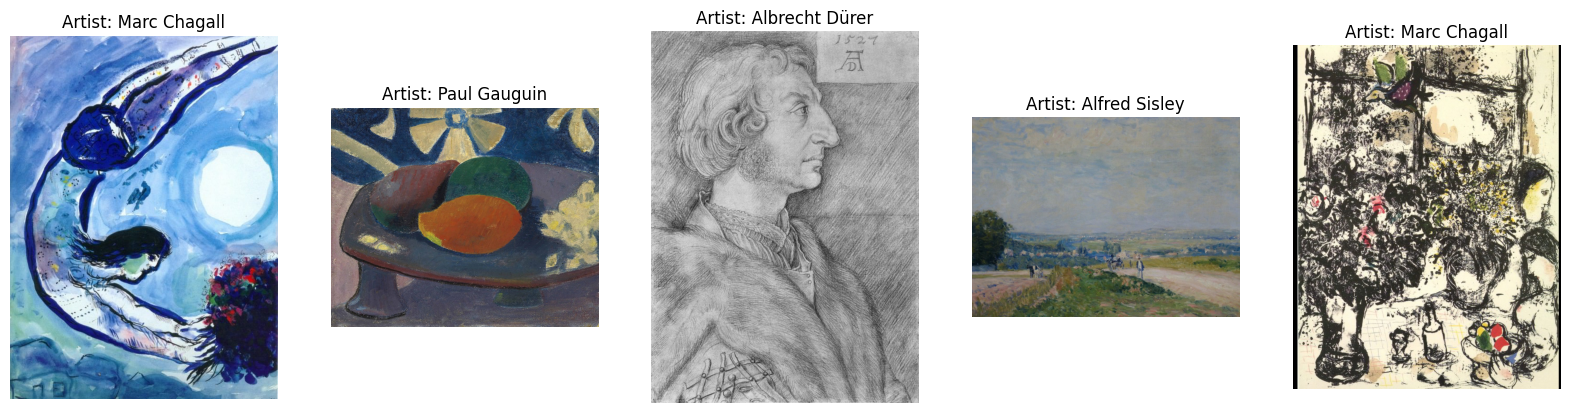

In [ ]:
artists_top_name = artists_top['name'].str.replace(' ', '_').values
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(data_dir, random_artist)))
    random_image_file = os.path.join(data_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [ ]:
batch_size = 32
img_height, img_width = 224, 224
artists_names= sorted(artist_df['name'].str.replace(' ', '_').tolist())

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    seed=123,
    subset='training',
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2, 
    seed=123,
    subset='validation', 
    image_size=(img_height, img_width), 
    batch_size=batch_size
)

Found 4299 files belonging to 11 classes.
Using 3440 files for training.
Found 4299 files belonging to 11 classes.
Using 859 files for validation.


In [ ]:
num_classes = 11
input_shape = (batch_size, img_height, img_width, 3)
model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(img_height, img_width, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
#model.add(Dense(512, activation='relu')) 
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       7

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
num_epochs = 50
start_time = time.time()
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=[early_stop]
)
end_time = time.time()
training_time = end_time - start_time

loss, accuracy = model.evaluate(val_ds)
print(f'Validation accuracy: {accuracy}')
print(f'Validation loss: {loss:.4f}')
training_time_minutes = round(training_time / 60, 2)
print(f"Training time: {training_time_minutes} minutes")

Epoch 1/50
108/108 [==============================] - 877s 7s/step - loss: 3.2637 - accuracy: 0.2558 - val_loss: 2.0823 - val_accuracy: 0.3539
Epoch 2/50
108/108 [==============================] - 19s 164ms/step - loss: 1.9824 - accuracy: 0.3744 - val_loss: 1.9642 - val_accuracy: 0.3667
Epoch 3/50
108/108 [==============================] - 18s 156ms/step - loss: 1.8596 - accuracy: 0.4247 - val_loss: 1.8399 - val_accuracy: 0.4342
Epoch 4/50
108/108 [==============================] - 18s 159ms/step - loss: 1.7615 - accuracy: 0.4549 - val_loss: 1.8261 - val_accuracy: 0.4144
Epoch 5/50
108/108 [==============================] - 18s 161ms/step - loss: 1.7049 - accuracy: 0.4808 - val_loss: 1.7983 - val_accuracy: 0.4470
Epoch 6/50
108/108 [==============================] - 18s 158ms/step - loss: 1.6735 - accuracy: 0.5017 - val_loss: 1.7789 - val_accuracy: 0.4633
Epoch 7/50
108/108 [==============================] - 18s 157ms/step - loss: 1.6095 - accuracy: 0.5163 - val_loss: 1.7809 - val_accu

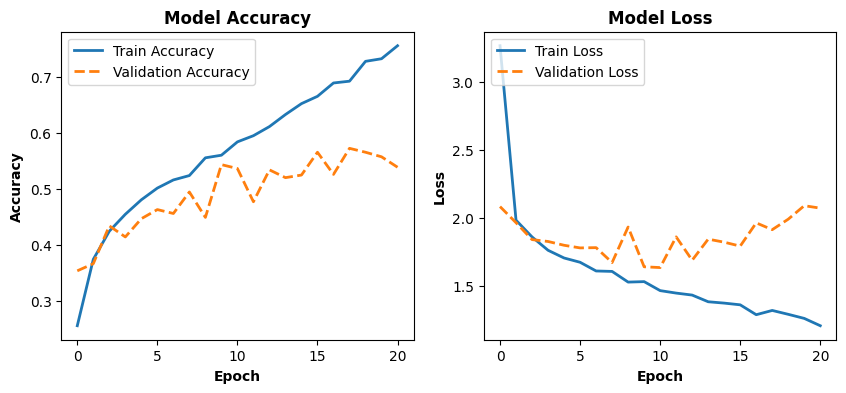

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(model_history.history['accuracy'], linestyle='-', linewidth=2, label='Train Accuracy')
ax1.plot(model_history.history['val_accuracy'], linestyle='--', linewidth=2, label='Validation Accuracy')
ax1.set_title('Model Accuracy', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_xlabel('Epoch', fontweight='bold')
ax1.legend(loc='upper left')
ax2.plot(model_history.history['loss'], linestyle='-', linewidth=2, label='Train Loss')
ax2.plot(model_history.history['val_loss'], linestyle='--', linewidth=2, label='Validation Loss')
ax2.set_title('Model Loss', fontweight='bold')
ax2.set_ylabel('Loss', fontweight='bold')
ax2.set_xlabel('Epoch', fontweight='bold')
ax2.legend(loc='upper left')
plt.show()

In [ ]:
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_class_labels = [val_ds.class_names[label] for label in val_labels]
y_pred = model.predict(val_ds) 
y_pred_classes = np.argmax(y_pred, axis=1) 
y_pred_classes = y_pred_classes.tolist()

artists_names = sorted(artist_df['name'].str.replace(' ', '_').tolist())
n_artists = len(artists_names)
artist_dict = {}
for i in range(n_artists):
    artist_dict[i] = artists_names[i]

artist_names_pred = [artist_dict[label] for label in y_pred_classes]
artist_names_true = val_class_labels

print(classification_report(artist_names_true, artist_names_pred, zero_division=0))

27/27 [==============================] - 4s 88ms/step
                       precision    recall  f1-score   support

      Albrecht_Dürer       0.00      0.00      0.00        56
       Albrecht_Dürer       0.00      0.00      0.00         0
        Alfred_Sisley       0.04      0.04      0.04        57
    Amedeo_Modigliani       0.00      0.00      0.00         0
        Andrei_Rublev       0.00      0.00      0.00         0
          Andy_Warhol       0.00      0.00      0.00         0
     Camille_Pissarro       0.00      0.00      0.00         0
           Caravaggio       0.00      0.00      0.00         0
         Claude_Monet       0.00      0.00      0.00         0
         Diego_Rivera       0.00      0.00      0.00         0
      Diego_Velazquez       0.00      0.00      0.00         0
          Edgar_Degas       0.18      0.30      0.22       132
       Francisco_Goya       0.00      0.00      0.00        58
         Marc_Chagall       0.00      0.00      0.00        42


In [ ]:
precision = precision_score(artist_names_true, artist_names_pred, average='macro', zero_division=0)
print("Precision of the model", precision)
recall = recall_score(artist_names_true, artist_names_pred, average='macro', zero_division=0)
print("Recall of the model", recall)
f1 = f1_score(artist_names_true, artist_names_pred, average='macro', zero_division=0)
print("F1-score of the model", f1)

Precision of the model 0.011291989664082689
Recall of the model 0.016527113237639553
F1-score of the model 0.013199977397298977


In [ ]:
report = classification_report(artist_names_true, artist_names_pred, zero_division=0)

f1_scores = {}
for line in report.split('\n')[2:-5]:
    line = line.split()
    if len(line) == 0:
        continue
    class_name = line[0]
    f1_score = float(line[-1])
    f1_scores[class_name] = f1_score

top_classes = sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 classes by f1-score:")
for class_name, f1_score in top_classes:
    print(class_name)


Top 5 classes by f1-score:
Vincent_van_Gogh
Edgar_Degas
Pablo_Picasso
Pierre-Auguste_Renoir
Paul_Gauguin
